In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
from tqdm.notebook import tqdm


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [6]:
class Task:
    def __init__(self, items_array):
        self.n = int(items_array[0][0])
        self.W = int(items_array[0][1])
        self.S = int(items_array[0][2])
        self.w = items_array[1:, 0]
        self.s = items_array[1:, 1]
        self.c = items_array[1:, 2]


class Individual:
    def __init__(self, genome):
        self.genome = genome

    def evaluate(self, task):
        if (self.genome * task.w).sum() <= task.W and (self.genome * task.s).sum() <= task.S:
            result = np.round((self.genome * task.c).sum(), 5)
        else:
            result = 0
        return result 

    def mutate(self, mutation_rate):
        genome_size = self.genome.shape[0]
        no_of_genes_to_change = int(np.ceil(genome_size * mutation_rate))
        genes_to_change = random.choices(range(genome_size), k=no_of_genes_to_change)
        self.genome[genes_to_change] = -self.genome[genes_to_change] + 1


class Population:
    def __init__(self, genome_size=None, pop_size=None):
        self.population = []
        if genome_size != None and pop_size != None:
            population_array = np.random.choice([0, 1], size=(pop_size, genome_size),  p=[0.85, 0.15])
            for genome in population_array:
                individual = Individual(genome)
                self.population.append(individual)
        self.size = len(self.population)

    def tournament(self, tournament_size, task):
        selected = random.choices(self.population, k=tournament_size)
        evaluation = [elem.evaluate(task) for elem in selected]
        idx_best_individual = evaluation.index(max(evaluation))
        return selected[idx_best_individual]

    def crossover(self, crossover_rate, task):
        parent_1 = self.tournament(TOURNAMENT_SIZE, task)
        parent_2 = self.tournament(TOURNAMENT_SIZE, task)
        if np.random.random() < crossover_rate:
            splitting_point = np.random.randint(1, len(parent_1.genome))
            result_genome = np.concatenate([parent_1.genome[:splitting_point], parent_2.genome[splitting_point:]])
            result = Individual(result_genome)
        else:
            result = parent_1
        return result

    def add_child(self, child):
        self.population.append(child)
        self.size = len(self.population)

    def best(self, task):
        evaluation = []
        for individual in self.population:
            evaluation.append(individual.evaluate(task))

        idx_best_individual = evaluation.index(max(evaluation))
        best = self.population[idx_best_individual]
        return best, best.evaluate(task) #osobink, wynik


def generate(output_file_path):
    n = np.random.randint(1000, 2000)
    W = np.random.randint(10000, 20000)
    S = np.random.randint(10000, 20000)
    while True:
        w = np.round(np.random.random(n) * 10 * W / n, 5)
        s = np.round(np.random.random(n) * 10 * S / n, 5)
        c = np.round(np.random.random(n) * n, 5)
        if w.sum() > 2 * W and s.sum() > 2 * S:
            break

    with open(output_file_path, 'w', newline='') as out:
        writer = csv.writer(out)
        writer.writerow([n, W, S])
        for i in range(n):
            writer.writerow([w[i], s[i], c[i]])


def read(input_file):
    arr = []
    input_file = open(input_file, "r")
    for line in input_file.readlines():
        arr.append([float(i) for i in line.split(',')])
    items_array = np.asarray(arr)
    return Task(items_array)


def genetic_algorithm(task, parameters):
    POPULATIONS_SIZE, TOURNAMENT_SIZE, CROSSOVER_RATE, MUTATION_RATE, ITERATIONS = parameters
    population = Population(genome_size=task.n, pop_size=POPULATIONS_SIZE)
    best_history = []  #  lista z wynikami kolejnych 
    the_best_individual, the_best_evaluation = population.best(task) 
    t = tqdm(range(ITERATIONS), desc='', leave=True)

    for _ in t:
        new_population = Population()
        for _ in range(population.size):
            child = population.crossover(CROSSOVER_RATE, task)
            child.mutate(MUTATION_RATE)
            new_population.add_child(child)
        
        best_individual, best_evaluation = population.best(task)  
        if best_evaluation > the_best_evaluation:
            the_best_individual = best_individual
            the_best_evaluation = best_evaluation
            
        best_history.append(best_evaluation)# liste z wynikami
        t.set_description("best_evaluation: {}".format(round(best_evaluation)))
        t.refresh()
        population = new_population
    return the_best_individual, best_history, the_best_evaluation  #  obiekt, lista, liczbe 

In [7]:
POPULATIONS_SIZE = 150
TOURNAMENT_SIZE = 25
CROSSOVER_RATE = 0.95
MUTATION_RATE = 0.001
ITERATIONS = 700 # na 700

test_histories = []    
output_file_path = "test_file.csv"
generate(output_file_path)
generated_task = read(output_file_path)

parameters = (POPULATIONS_SIZE, TOURNAMENT_SIZE, CROSSOVER_RATE, MUTATION_RATE, ITERATIONS) 

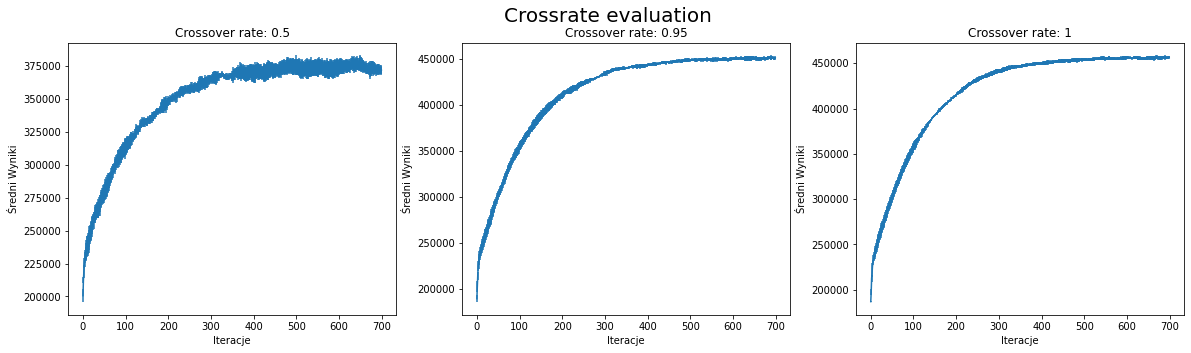

In [8]:
TEST_CASES = 5
cross_rate_test_set = [0.5,0.95,1]

fig = plt.gcf()
fig.set_size_inches(20,5)
fig.suptitle("Crossrate evaluation", fontsize=20)

for i, cross_rate in enumerate(cross_rate_test_set):
    parameters = (POPULATIONS_SIZE, TOURNAMENT_SIZE, cross_rate, MUTATION_RATE, ITERATIONS) 
    test_histories = [] 
    for _ in range(TEST_CASES):
        best, best_history, best_evaluation = genetic_algorithm(generated_task, parameters) #best osobinik indvidual , lsita z liczbami, wynik najlepszego osobnika
        test_histories.append(best_history)

    test_histories_array = np.array(test_histories)
    y = test_histories_array.mean(axis=0)
    x = np.array(range(test_histories_array.shape[1]))
    y_err = test_histories_array.std(axis=0)
    
    
    ax = plt.subplot(1, len(cross_rate_test_set), i+1)
    ax.set_title("Crossover rate: {}".format(cross_rate))
    ax.errorbar(x=x, y=y, yerr=y_err)
    ax.set_xlabel("Iteracje")
    ax.set_ylabel("Średni Wyniki")
plt.show() 

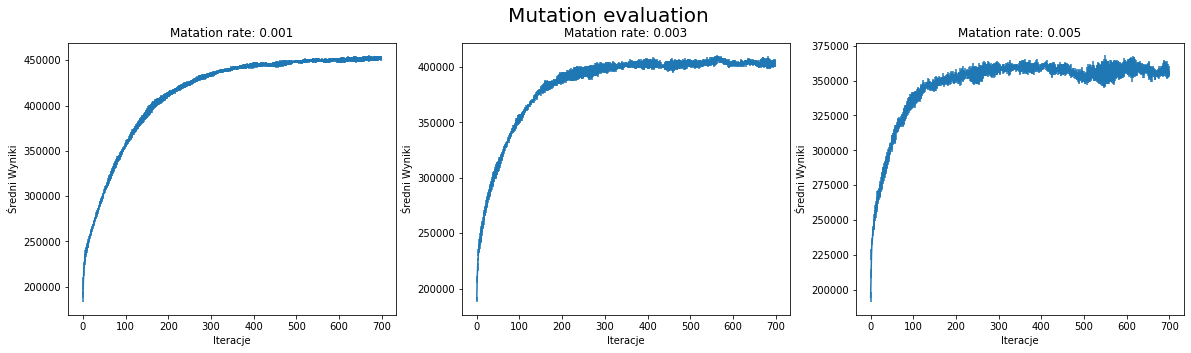

In [9]:
TEST_CASES = 5
mutation_rate_test_set = [0.001,0.003,0.005]

fig = plt.gcf()
fig.set_size_inches(20,5)
fig.suptitle("Mutation evaluation", fontsize=20)

for i, mutation_rate in enumerate(mutation_rate_test_set):
    parameters = (POPULATIONS_SIZE, TOURNAMENT_SIZE, CROSSOVER_RATE, mutation_rate, ITERATIONS) 
    test_histories = []
    for _ in range(TEST_CASES):
        best, best_history, best_evaluation = genetic_algorithm(generated_task, parameters)
        test_histories.append(best_history)

    test_histories_array = np.array(test_histories)
    y = test_histories_array.mean(axis=0)
    x = np.array(range(test_histories_array.shape[1]))
    y_err = test_histories_array.std(axis=0)
    
    
    ax = plt.subplot(1, len(cross_rate_test_set), i+1)
    ax.set_title("Matation rate: {}".format(mutation_rate))
    ax.errorbar(x=x, y=y, yerr=y_err)
    ax.set_xlabel("Iteracje")
    ax.set_ylabel("Średni Wyniki")
plt.show()

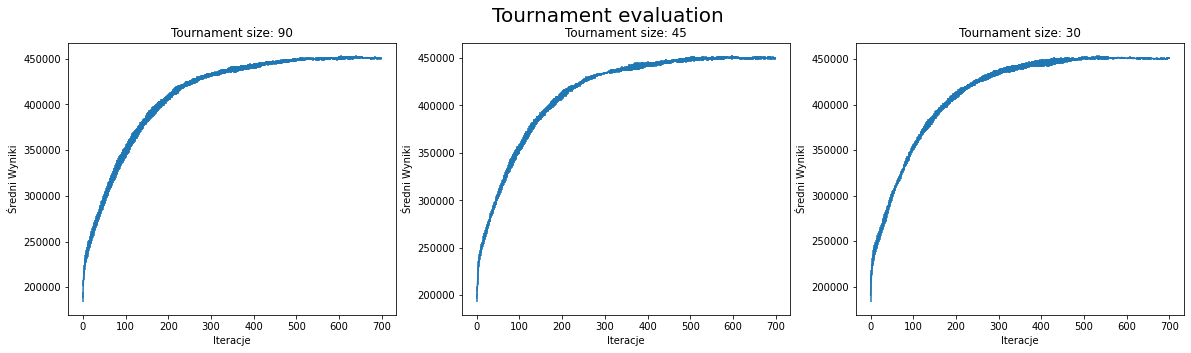

In [11]:
TEST_CASES = 5
A = np.array([0.6,0.3,0.2])*POPULATIONS_SIZE

tournament_size_test_set= A.astype(int)

fig = plt.gcf()
fig.set_size_inches(20,5)
fig.suptitle("Tournament evaluation", fontsize=20)

for i, tournament_size in enumerate(tournament_size_test_set):
    parameters = (POPULATIONS_SIZE, tournament_size, CROSSOVER_RATE, MUTATION_RATE, ITERATIONS) 
    test_histories = []
    for _ in range(TEST_CASES):
        best, best_history, best_evaluation = genetic_algorithm(generated_task, parameters)
        test_histories.append(best_history)

    test_histories_array = np.array(test_histories)
    y = test_histories_array.mean(axis=0)
    x = np.array(range(test_histories_array.shape[1]))
    y_err = test_histories_array.std(axis=0)
    
    
    ax = plt.subplot(1, len(cross_rate_test_set), i+1)
    ax.set_title("Tournament size: {}".format(tournament_size))
    ax.errorbar(x=x, y=y, yerr=y_err)
    ax.set_xlabel("Iteracje")
    ax.set_ylabel("Średni Wyniki")
plt.show()

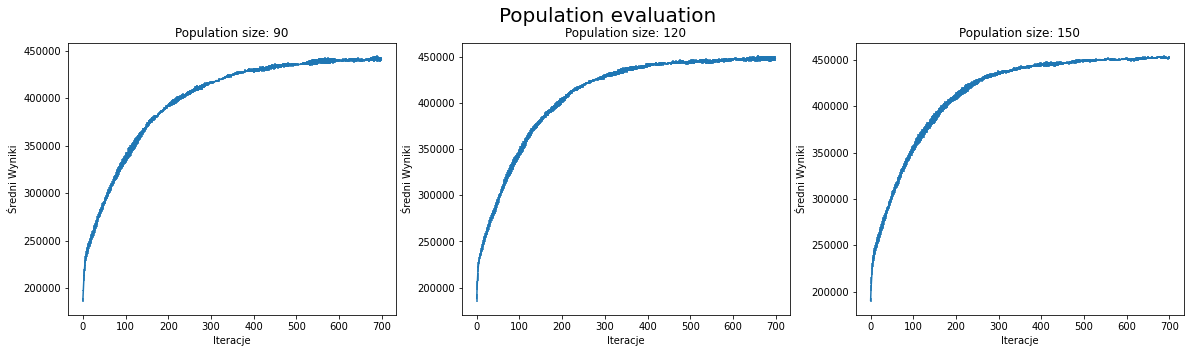

In [10]:
TEST_CASES = 5
population_size_test_set = np.array([90,120,150])

fig = plt.gcf()
fig.set_size_inches(20,5)
fig.suptitle("Population evaluation", fontsize=20)

for i, population_size in enumerate(population_size_test_set):
    parameters = (population_size, TOURNAMENT_SIZE, CROSSOVER_RATE, MUTATION_RATE, ITERATIONS) 
    test_histories = []
    for _ in range(TEST_CASES):
        best, best_history, best_evaluation = genetic_algorithm(generated_task, parameters)
        test_histories.append(best_history)

    test_histories_array = np.array(test_histories)
    y = test_histories_array.mean(axis=0)
    x = np.array(range(test_histories_array.shape[1]))
    y_err = test_histories_array.std(axis=0)
    
    
    ax = plt.subplot(1, len(cross_rate_test_set), i+1)
    ax.set_title("Population size: {}".format(population_size))
    ax.errorbar(x=x, y=y, yerr=y_err)
    ax.set_xlabel("Iteracje")
    ax.set_ylabel("Średni Wyniki")
plt.show()